In [19]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\dim\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [20]:
average_monhtly_wage=pd.read_csv("WAG_C_M.csv",sep=";",index_col=["month"],
                                 parse_dates=True,dayfirst=True)

Text(0,0.5,u'Average monhtly wage')

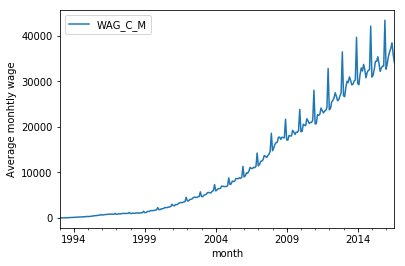

In [21]:
plt.figure(figsize=(15,7))
average_monhtly_wage.plot()
plt.ylabel("Average monhtly wage")

На графике заметен восходящий тренд,сезонность и повышение дисперсии со временем

Проверка стоционарности и STL-декомпозиция ряда

Критерий Дикки-Фуллера: p=0.991850


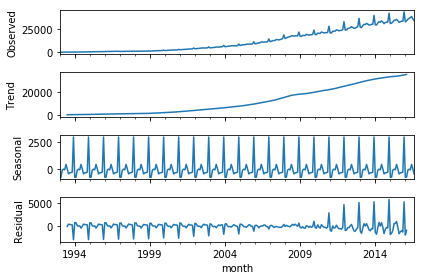

In [22]:
plt.figure(figsize=(20,10))
sm.tsa.seasonal_decompose(average_monhtly_wage.WAG_C_M).plot()
print("Критерий Дикки-Фуллера: p=%f" %sm.tsa.stattools.adfuller(average_monhtly_wage.WAG_C_M)[1])

Критерий Дика-Фуллера не отвергает гипотезу стационарности, виден тренд и сезонность

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии

Оптимальный размер преобразований бокса-кокса 0.263202
Критерий Дикки-Фуллера p=0.696899


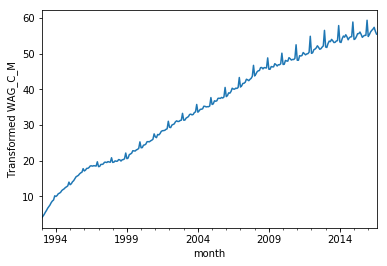

In [23]:
average_monhtly_wage["WAG_C_M_boxcox"],lmbda=stats.boxcox(average_monhtly_wage.WAG_C_M)
plt.ylabel("Transformed WAG_C_M")
average_monhtly_wage.WAG_C_M_boxcox.plot()
print("Оптимальный размер преобразований бокса-кокса %f" % lmbda)
print("Критерий Дикки-Фуллера p=%f" % sm.tsa.stattools.adfuller(average_monhtly_wage.WAG_C_M_boxcox)[1])

Критерий Дикки-Фуллера p=0.696899


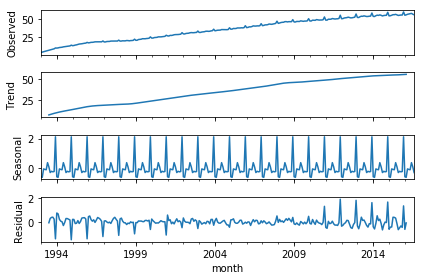

In [35]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(average_monhtly_wage.WAG_C_M_boxcox).plot()
print("Критерий Дикки-Фуллера p=%f" % sm.tsa.stattools.adfuller(average_monhtly_wage.WAG_C_M_boxcox)[1])

На графике виден тренд и сезонность.Критерий Дикки-Фуллера не отвергает гипотезу о нестационарности ряда.

Попробуем провести сезонное дифференцирование ряда

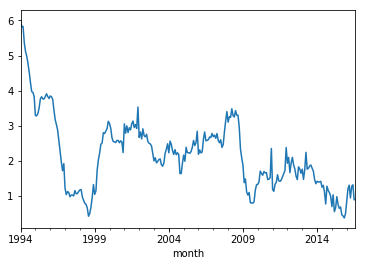

In [34]:
average_monhtly_wage["WAG_C_M_boxcox_diff"]=average_monhtly_wage.WAG_C_M_boxcox-average_monhtly_wage.WAG_C_M_boxcox.shift(12)
average_monhtly_wage.WAG_C_M_boxcox_diff[12:].plot()

Критерий Дикки-Фуллера p=0.014697


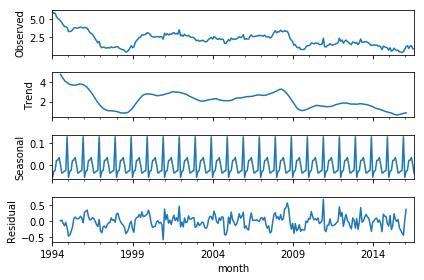

In [33]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(average_monhtly_wage.WAG_C_M_boxcox_diff[12:]).plot()
print("Критерий Дикки-Фуллера p=%f" % sm.tsa.stattools.adfuller(average_monhtly_wage.WAG_C_M_boxcox_diff[12:])[1])

Критерий Дикки-Фуллера отвергает гипотезу нестационарности ряда, но на графике все еще виден тренд.

Попробуем добавить обычное дифференцирование.

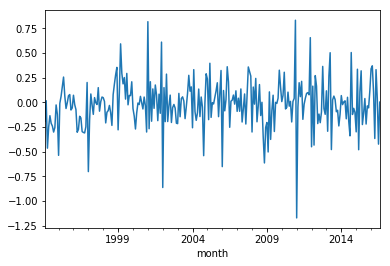

In [37]:
average_monhtly_wage["WAG_C_M_boxcox_diff2"]=average_monhtly_wage.WAG_C_M_boxcox_diff-average_monhtly_wage.WAG_C_M_boxcox_diff.shift(1)
average_monhtly_wage.WAG_C_M_boxcox_diff2[13:].plot()

Критерий Дикки-Фуллера p=0.000000


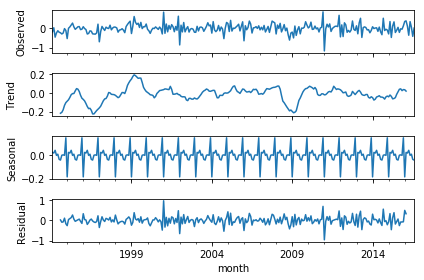

In [40]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(average_monhtly_wage.WAG_C_M_boxcox_diff2[13:]).plot()
print("Критерий Дикки-Фуллера p=%f" % sm.tsa.stattools.adfuller(average_monhtly_wage.WAG_C_M_boxcox_diff2[13:])[1])

Критерий Дикки-Фуллера отвергает гипотезу нестационарности ряда с еще меньшим p-value.Тренд на графике больше не виден.

## Подбор модели

Построим ACF и PACF полученного ряда

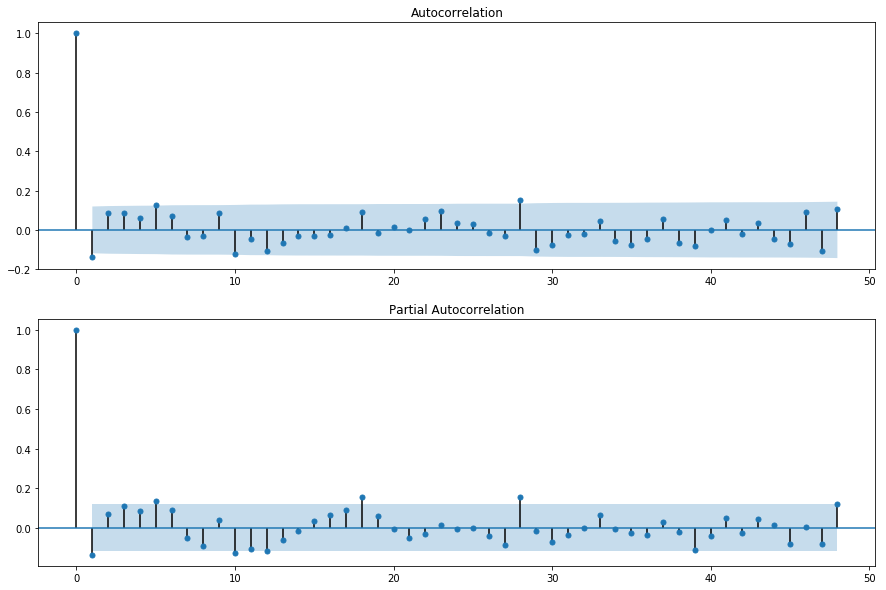

In [52]:
plt.figure(figsize=(15,10))
ax=plt.subplot(211)
sm.graphics.tsa.plot_acf(average_monhtly_wage.WAG_C_M_boxcox_diff2[13:].values.squeeze(),
                         lags=48,ax=ax)
ax=plt.subplot(212)
sm.graphics.tsa.plot_pacf(average_monhtly_wage.WAG_C_M_boxcox_diff2[13:].values.squeeze(),
                          lags=48,ax=ax)
pylab.show()

Начальные приближения: Q=0,q=1,P=1,p=1

In [53]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [59]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print len(parameters_list)

8


In [61]:
%%time
results=[]
best_aic=float("inf")
warnings.filterwarnings("ignore")
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(average_monhtly_wage.WAG_C_M_boxcox,
                                        order=(param[0],d,param[1]),
                                       seasonal_order=(param[2],D,param[3],12)).fit(disp=-1)
    except ValueError:
        print("wrong parameters:",param)
        continue
    aic=model.aic
    if aic<best_aic:
        best_model=model
        best_aic=aic
        best_param=param
    results.append([param,model.aic])
warnings.filterwarnings("default")

('wrong parameters:', (0, 0, 0, 0))
Wall time: 5.08 s


In [62]:
results_table=pd.DataFrame(results)
results_table.columns=["parameters","aic"]
print(results_table.sort_values(by="aic",ascending=True))

     parameters       aic
4  (1, 0, 1, 0)  0.340521
2  (0, 1, 1, 0)  1.170768
6  (1, 1, 1, 0)  2.021911
3  (1, 0, 0, 0)  2.625709
1  (0, 1, 0, 0)  3.369832
5  (1, 1, 0, 0)  4.003439
0  (0, 0, 1, 0)  4.268898


Лучшая модель

In [63]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     WAG_C_M_boxcox   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Sat, 07 Jul 2018   AIC                              0.341
Time:                                    13:05:26   BIC                             11.287
Sample:                                01-01-1993   HQIC                             4.729
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

Ее остатки

Критерий Стьюдента p=0.090793
Критерий Дикки-Фуллера p=0.000003


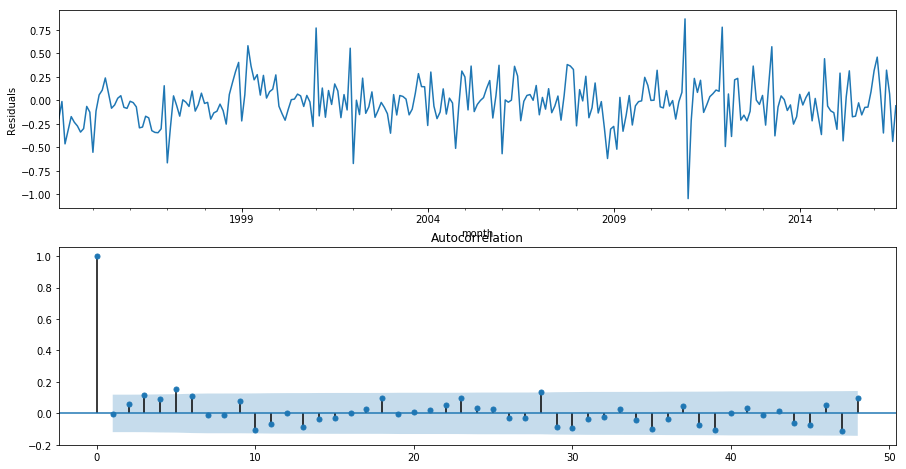

In [65]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel("Residuals")
ax=plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(),lags=48,ax=ax)
print("Критерий Стьюдента p=%f"% stats.ttest_1samp(best_model.resid[13:],0)[1])
print("Критерий Дикки-Фуллера p=%f"%sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

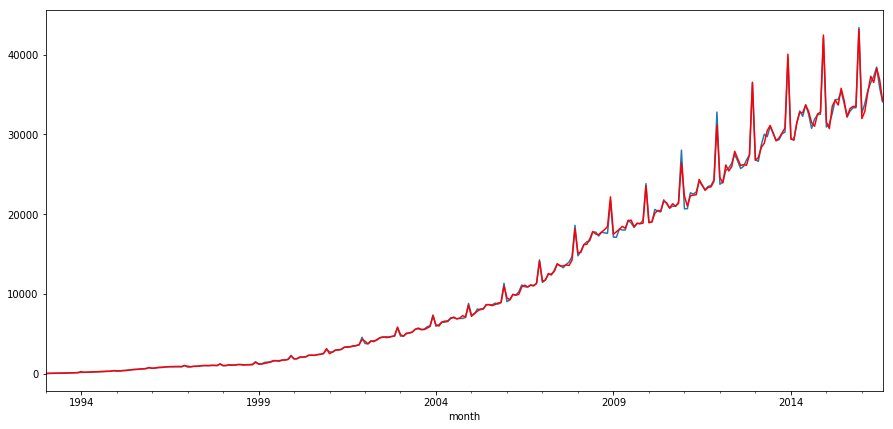

In [67]:
average_monhtly_wage["model"]=invboxcox(best_model.fittedvalues,lmbda)
plt.figure(figsize=(15,7))
average_monhtly_wage.WAG_C_M.plot()
average_monhtly_wage.model.plot(color="r")

По графику видно что модель достаточно хорошо описывает данные.

## Строим прогноз

Text(0,0.5,u'WAG_C_M')

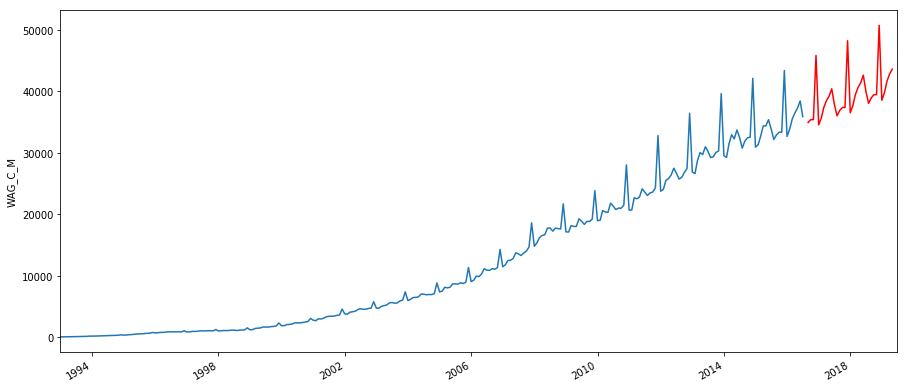

In [70]:
average_monhtly_wage2=average_monhtly_wage[["WAG_C_M"]]
date_list=[datetime.datetime.strptime("2016-08-01","%Y-%m-%d")+relativedelta(months=x) for x in range(0,36)]
future=pd.DataFrame(index=date_list,columns=average_monhtly_wage2.columns)
average_monhtly_wage2=pd.concat([future,average_monhtly_wage2])
average_monhtly_wage2["forecast"]=invboxcox(best_model.predict(start=284,end=316),lmbda)
plt.figure(figsize=(15,7))
average_monhtly_wage2.WAG_C_M.plot()
average_monhtly_wage2.forecast.plot(color="r")
plt.ylabel("WAG_C_M")

По графику видно что прогноз хорошо описывает данные